In [1]:
%pip install cvxpy
%pip install cvxopt
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import skimage as ski
import math

import skimage.io
import skimage.transform

import scipy.fftpack as spfft

Original size:  (292, 228)
Rescaled size:  (53, 41)


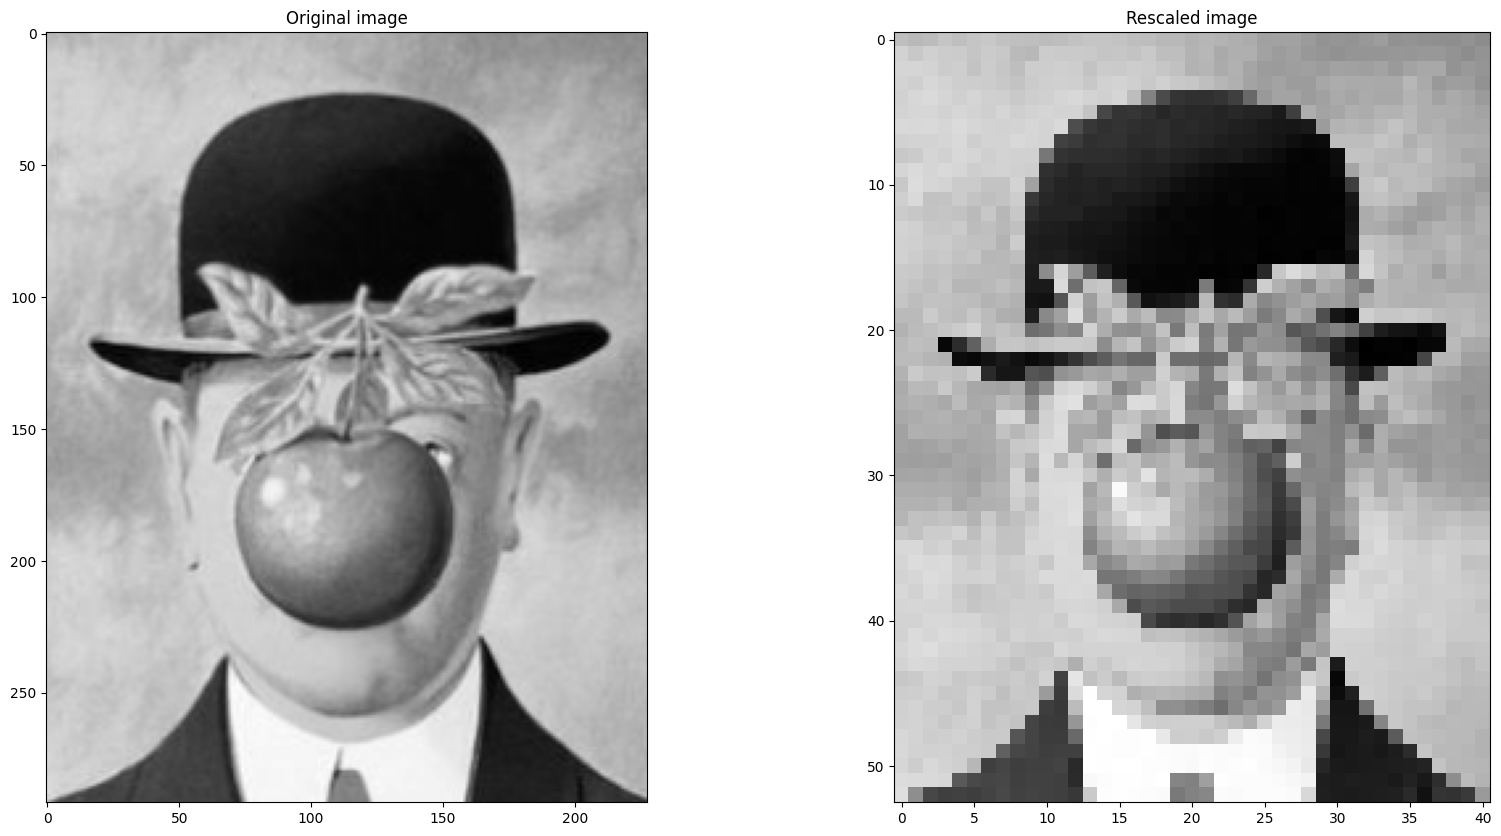

In [3]:
# Import image and rescale
img_path = 'SonOfMan.png'

# Read image
img_og = ski.io.imread(img_path)

# Check if the image has an alpha channel and remove it if present
if img_og.shape[2] == 4:
    img_og = img_og[:, :, :3]

# Convert to grayscale and visualize
img_og = ski.color.rgb2gray(img_og)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img_og, cmap='gray')
ax[0].set_title("Original image")

print("Original size: ", img_og.shape)

# Resize image
img = ski.transform.rescale(img_og, 0.18, anti_aliasing=False)

print("Rescaled size: ", img.shape)

ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image")
fig.savefig('original_img.png')

In [4]:
# constrauct forward and inverse DCT matrices

# construct DCT matrix
def construct_DCT_Mat( Nx, Ny ):

  # input : Nx number of columns of image
  #         Ny number of rows of image

  # output: D DCT matrix mapping image.flatten() to
  #         DCT(image).flatten()

  Dx = spfft.dct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.dct(np.eye(Ny), axis = 0, norm='ortho')

  D = np.kron(Dy, Dx)

  return D

# construct inverse DCT matrix
def construct_iDCT_Mat( Nx, Ny ):

  # input : Nx number of columns of image
  #         Ny number of rows of image

  # output: iD iDCT matrix mapping DCT(image).flatten() to
  #         image.flatten()

  Dx = spfft.idct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.idct(np.eye(Ny), axis = 0, norm = 'ortho')

  D = np.kron(Dy, Dx)

  return D

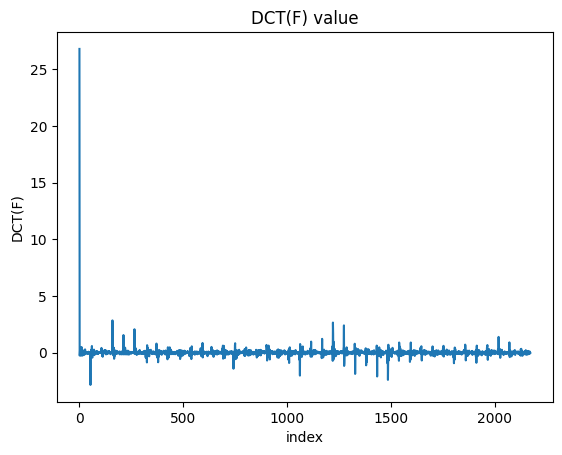

In [5]:
vec_F = np.ndarray.flatten(img)
DCT = construct_DCT_Mat(53, 41)
iDCT = construct_iDCT_Mat(53, 41)
DCT_F = np.matmul(DCT, vec_F)
plt.plot(DCT_F)
plt.title('DCT(F) value')
plt.xlabel('index')
plt.ylabel('DCT(F)')
plt.savefig('DCT_value.png')

In [6]:
sorted_DCT_F = np.sort(abs(DCT_F), axis=None)
sorted_DCT_F = sorted_DCT_F[::-1]
top_5 = sorted_DCT_F[0:math.floor(0.05*len(sorted_DCT_F))]
top_10 = sorted_DCT_F[0:math.floor(0.1*len(sorted_DCT_F))]
top_20 = sorted_DCT_F[0:math.floor(0.2*len(sorted_DCT_F))]
top_40 = sorted_DCT_F[0:math.floor(0.4*len(sorted_DCT_F))]

In [7]:
top_5_thre = top_5[len(top_5) - 1]
top_10_thre = top_10[len(top_10) - 1]
top_20_thre = top_20[len(top_20) - 1]
top_40_thre = top_40[len(top_40) - 1]

In [8]:
DCT_F_5 = np.copy(DCT_F)
DCT_F_10 = np.copy(DCT_F)
DCT_F_20 = np.copy(DCT_F)
DCT_F_40 = np.copy(DCT_F)
for i in range(len(DCT_F)):
    if abs(DCT_F_5[i]) < top_5_thre:
        DCT_F_5[i] = 0
    if abs(DCT_F_10[i]) < top_10_thre:
        DCT_F_10[i] = 0
    if abs(DCT_F_20[i]) < top_20_thre:
        DCT_F_20[i] = 0
    if abs(DCT_F_40[i]) < top_40_thre:
        DCT_F_40[i] = 0

image_5 = np.matmul(iDCT, DCT_F_5).reshape(53,41)
image_10 = np.matmul(iDCT, DCT_F_10).reshape(53,41)
image_20 = np.matmul(iDCT, DCT_F_20).reshape(53,41)
image_40 = np.matmul(iDCT, DCT_F_40).reshape(53,41)

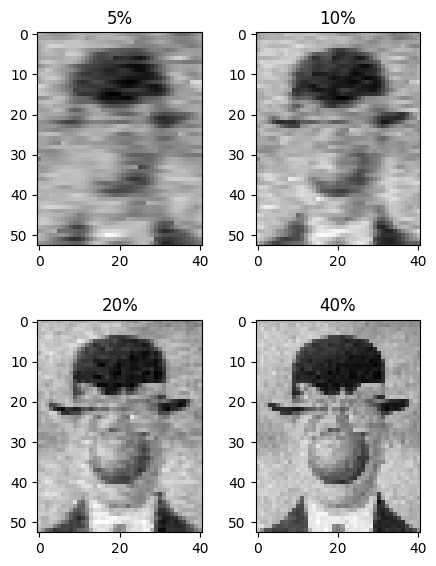

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
ax[0,0].imshow(image_5, cmap = 'gray')
ax[0,0].set_title("5%")
ax[0,1].imshow(image_10, cmap='gray')
ax[0,1].set_title("10%")
ax[1,0].imshow(image_20, cmap='gray')
ax[1,0].set_title("20%")
ax[1,1].imshow(image_40, cmap='gray')
ax[1,1].set_title("40%")
plt.subplots_adjust(left=0.4,
                    bottom=0.1,
                    right=0.6,
                    top=0.6,
                    wspace=0.2,
                    hspace=0.35)
fig.savefig('Top_x_percent_imag.png')

In [10]:
N = len(vec_F)
M = math.floor(0.2*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l1 = cvx.Minimize(cvx.norm(x,1))
constraints_l1 = [A*x == y]
prob_l1 = cvx.Problem(objective_l1, constraints_l1)
prob_l1.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l1 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 28 09:38:45 PM: Your problem has 2173 variables, 434 constraints, and 0 parameters.
(CVXPY) Jul 28 09:38:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 09:38:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 09:38:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 09:38:45 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:38:45 PM: Compiling problem (target solver=CVXOPT)

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 28 09:38:45 PM: Finished problem compilation (took 2.994e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:38:45 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.6289e-13  1.5664e-13  1e+04  4e+02  4e-16  1e+00
 1:  3.1982e+01  3.2113e+01  6e+03  2e+02  2e-16  6e-01
 2:  4.7359e+01  4.7688e+01  2e+03  6e+01  2e-16  5e-01
 3:  7.5814e+01  7.5955e+01  9e+02  3e+01  3e-16  2e-01
 4:  1.0456e+02  1.0462e+02  4e+02  1e+01  3e-16  9e-02
 5:  1.2611e+02  1.2613e+02  2e+02  5e+00  4e-16  4e-02
 6:  1.3535e+02  1.3536e+02  7e+01  2e+00  5e-16  2e-02
 7:  1.3948e+02  1.3948e+02  3e+01  9e-01  7e-16  7e-03
 8:  1.4096e+02  1.4096e+02  1e+01  4e-01  6e-16  3e-03
 9:  1.4175e+02  1.4176e+02  6e+00  2e-01  6e

In [11]:
N = len(vec_F)
M = math.floor(0.2*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l2 = cvx.Minimize(cvx.norm(x,1))
constraints_l2 = [A*x == y]
prob_l2 = cvx.Problem(objective_l2, constraints_l2)
prob_l2.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l2 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 28 09:39:44 PM: Your problem has 2173 variables, 434 constraints, and 0 parameters.
(CVXPY) Jul 28 09:39:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 09:39:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 09:39:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 09:39:44 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:39:44 PM: Compiling problem (target solver=CVXOPT)

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 28 09:39:45 PM: Finished problem compilation (took 2.871e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:39:45 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.0833e-13  1.1077e-13  1e+04  4e+02  4e-16  1e+00
 1:  3.1825e+01  3.1951e+01  6e+03  2e+02  3e-16  5e-01
 2:  4.9164e+01  4.9480e+01  2e+03  6e+01  2e-16  5e-01
 3:  7.9953e+01  8.0089e+01  9e+02  3e+01  3e-16  2e-01
 4:  1.1350e+02  1.1356e+02  4e+02  1e+01  5e-16  8e-02
 5:  1.3523e+02  1.3526e+02  2e+02  5e+00  5e-16  3e-02
 6:  1.4373e+02  1.4374e+02  7e+01  2e+00  5e-16  2e-02
 7:  1.4797e+02  1.4798e+02  3e+01  9e-01  5e-16  7e-03
 8:  1.4983e+02  1.4984e+02  1e+01  4e-01  6e-16  3e-03
 9:  1.5052e+02  1.5053e+02  6e+00  2e-01  6e

In [12]:
N = len(vec_F)
M = math.floor(0.2*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l3 = cvx.Minimize(cvx.norm(x,1))
constraints_l3 = [A*x == y]
prob_l3 = cvx.Problem(objective_l3, constraints_l3)
prob_l3.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l3 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 28 09:40:40 PM: Your problem has 2173 variables, 434 constraints, and 0 parameters.
(CVXPY) Jul 28 09:40:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 09:40:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 09:40:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 09:40:40 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:40:40 PM: Compiling problem (target solver=CVXOPT)

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 28 09:40:40 PM: Finished problem compilation (took 2.811e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:40:40 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  1.2287e-13  1.1821e-13  1e+04  4e+02  4e-16  1e+00
 1:  3.1950e+01  3.2084e+01  6e+03  2e+02  3e-16  6e-01
 2:  4.5741e+01  4.6078e+01  2e+03  6e+01  4e-16  5e-01
 3:  7.4151e+01  7.4284e+01  8e+02  3e+01  3e-16  2e-01
 4:  1.0438e+02  1.0443e+02  4e+02  1e+01  4e-16  8e-02
 5:  1.2553e+02  1.2555e+02  1e+02  4e+00  7e-16  3e-02
 6:  1.3290e+02  1.3291e+02  7e+01  2e+00  6e-16  2e-02
 7:  1.3653e+02  1.3654e+02  3e+01  1e+00  6e-16  7e-03
 8:  1.3863e+02  1.3863e+02  1e+01  3e-01  6e-16  3e-03
 9:  1.3930e+02  1.3930e+02  5e+00  1e-01  6e

In [13]:
recovery_l1 = recovery_l1.reshape(53,41)
recovery_l2 = recovery_l2.reshape(53,41)
recovery_l3 = recovery_l3.reshape(53,41)

In [14]:
N = len(vec_F)
M = math.floor(0.4*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l4 = cvx.Minimize(cvx.norm(x,1))
constraints_l4 = [A*x == y]
prob_l4 = cvx.Problem(objective_l4, constraints_l4)
prob_l4.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l4 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 28 09:41:39 PM: Your problem has 2173 variables, 869 constraints, and 0 parameters.
(CVXPY) Jul 28 09:41:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 09:41:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 09:41:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 09:41:39 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:41:39 PM: Compiling problem (target solver=CVXOPT)

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 28 09:41:39 PM: Applying reduction CVXOPT
(CVXPY) Jul 28 09:41:39 PM: Finished problem compilation (took 4.567e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:41:39 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.0981e-13  2.5394e-13  3e+04  8e+02  6e-16  1e+00
 1:  3.2287e+01  3.2635e+01  1e+04  3e+02  3e-16  8e-01
 2:  5.1543e+01  5.1729e+01  1e+03  4e+01  2e-16  2e-01
 3:  1.1029e+02  1.1037e+02  6e+02  2e+01  4e-16  1e-01
 4:  1.6266e+02  1.6268e+02  2e+02  6e+00  7e-16  4e-02
 5:  1.8614e+02  1.8615e+02  8e+01  2e+00  7e-16  1e-02
 6:  1.9604e+02  1.9605e+02  3e+01  9e-01  8e-16  6e-03
 7:  1.9941e+02  1.9941e+02  1e+01  4e-01  9e-16  2e-03
 8:  2.0068e+02  2.0068e+02  6e+00  2e-01  1e-1

In [15]:
N = len(vec_F)
M = math.floor(0.4*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l5 = cvx.Minimize(cvx.norm(x,1))
constraints_l5 = [A*x == y]
prob_l5 = cvx.Problem(objective_l5, constraints_l5)
prob_l5.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l5 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 28 09:43:05 PM: Your problem has 2173 variables, 869 constraints, and 0 parameters.
(CVXPY) Jul 28 09:43:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 09:43:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 09:43:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 09:43:05 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:43:05 PM: Compiling problem (target solver=CVXOPT)

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 28 09:43:05 PM: Applying reduction CVXOPT
(CVXPY) Jul 28 09:43:05 PM: Finished problem compilation (took 5.563e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:43:05 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.4113e-13  2.5838e-13  2e+04  8e+02  6e-16  1e+00
 1:  3.2197e+01  3.2531e+01  1e+04  3e+02  3e-16  8e-01
 2:  5.3944e+01  5.4124e+01  1e+03  4e+01  2e-16  2e-01
 3:  1.1462e+02  1.1470e+02  6e+02  2e+01  4e-16  1e-01
 4:  1.5925e+02  1.5928e+02  2e+02  7e+00  5e-16  4e-02
 5:  1.8735e+02  1.8737e+02  7e+01  2e+00  8e-16  1e-02
 6:  1.9649e+02  1.9650e+02  3e+01  9e-01  9e-16  6e-03
 7:  1.9945e+02  1.9945e+02  1e+01  4e-01  8e-16  3e-03
 8:  2.0107e+02  2.0107e+02  6e+00  2e-01  9e-1

In [16]:
N = len(vec_F)
M = math.floor(0.4*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l6 = cvx.Minimize(cvx.norm(x,1))
constraints_l6 = [A*x == y]
prob_l6 = cvx.Problem(objective_l6, constraints_l6)
prob_l6.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l6 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 28 09:44:49 PM: Your problem has 2173 variables, 869 constraints, and 0 parameters.
(CVXPY) Jul 28 09:44:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 09:44:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 09:44:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 09:44:49 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:44:49 PM: Compiling problem (target solver=CVXOPT)

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 6 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 28 09:44:50 PM: Applying reduction CVXOPT
(CVXPY) Jul 28 09:44:50 PM: Finished problem compilation (took 4.672e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:44:50 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.7098e-13  2.8060e-13  3e+04  8e+02  5e-16  1e+00
 1:  3.2169e+01  3.2508e+01  1e+04  3e+02  3e-16  8e-01
 2:  5.2568e+01  5.2751e+01  2e+03  5e+01  2e-16  2e-01
 3:  1.0872e+02  1.0880e+02  6e+02  2e+01  4e-16  1e-01
 4:  1.5710e+02  1.5713e+02  2e+02  6e+00  6e-16  4e-02
 5:  1.7967e+02  1.7968e+02  9e+01  3e+00  7e-16  2e-02
 6:  1.9156e+02  1.9156e+02  3e+01  1e+00  8e-16  6e-03
 7:  1.9509e+02  1.9509e+02  1e+01  4e-01  9e-16  3e-03
 8:  1.9658e+02  1.9658e+02  5e+00  2e-01  9e-1

In [17]:
recovery_l4 = recovery_l4.reshape(53,41)
recovery_l5 = recovery_l5.reshape(53,41)
recovery_l6 = recovery_l6.reshape(53,41)

In [18]:
N = len(vec_F)
M = math.floor(0.6*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l7 = cvx.Minimize(cvx.norm(x,1))
constraints_l7 = [A*x == y]
prob_l7 = cvx.Problem(objective_l7, constraints_l7)
prob_l7.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l7 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 28 09:46:54 PM: Your problem has 2173 variables, 1303 constraints, and 0 parameters.
(CVXPY) Jul 28 09:46:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 09:46:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 09:46:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 09:46:54 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:46:54 PM: Compiling problem (target solver=CVXOPT

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 7 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 28 09:46:54 PM: Applying reduction CVXOPT
(CVXPY) Jul 28 09:46:54 PM: Finished problem compilation (took 7.426e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:46:54 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.1915e-13  3.2798e-13  4e+04  1e+03  8e-16  1e+00
 1:  3.2892e+01  3.3509e+01  1e+04  4e+02  4e-16  1e+00
 2:  5.5430e+01  5.5536e+01  2e+03  6e+01  3e-16  2e-01
 3:  1.2953e+02  1.2956e+02  6e+02  2e+01  6e-16  5e-02
 4:  1.9774e+02  1.9775e+02  2e+02  5e+00  8e-16  2e-02
 5:  2.2712e+02  2.2712e+02  6e+01  2e+00  1e-15  8e-03
 6:  2.3857e+02  2.3857e+02  2e+01  6e-01  1e-15  3e-03
 7:  2.4224e+02  2.4224e+02  8e+00  2e-01  1e-15  1e-03
 8:  2.4322e+02  2.4322e+02  5e+00  1e-01  1e-1

In [19]:
N = len(vec_F)
M = math.floor(0.6*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l8 = cvx.Minimize(cvx.norm(x,1))
constraints_l8 = [A*x == y]
prob_l8 = cvx.Problem(objective_l8, constraints_l8)
prob_l8.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l8 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 28 09:49:24 PM: Your problem has 2173 variables, 1303 constraints, and 0 parameters.
(CVXPY) Jul 28 09:49:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 09:49:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 09:49:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 09:49:24 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:49:24 PM: Compiling problem (target solver=CVXOPT

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 8 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 28 09:49:24 PM: Applying reduction CVXOPT
(CVXPY) Jul 28 09:49:25 PM: Finished problem compilation (took 6.864e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:49:25 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.2552e-13  3.5841e-13  4e+04  1e+03  7e-16  1e+00
 1:  3.2818e+01  3.3431e+01  1e+04  4e+02  3e-16  1e+00
 2:  5.5683e+01  5.5786e+01  2e+03  6e+01  3e-16  2e-01
 3:  1.2872e+02  1.2876e+02  6e+02  2e+01  4e-16  6e-02
 4:  1.9579e+02  1.9580e+02  2e+02  6e+00  8e-16  2e-02
 5:  2.2966e+02  2.2967e+02  6e+01  2e+00  1e-15  7e-03
 6:  2.4006e+02  2.4006e+02  2e+01  7e-01  1e-15  3e-03
 7:  2.4380e+02  2.4380e+02  1e+01  3e-01  1e-15  2e-03
 8:  2.4585e+02  2.4585e+02  4e+00  1e-01  1e-1

In [20]:
N = len(vec_F)
M = math.floor(0.6*N)
I = np.eye(N)
random_matrix = np.random.permutation(I)
B = random_matrix[0:M,:]
y = np.dot(B, vec_F)
A = np.dot(B, iDCT)
x = cvx.Variable(N)
objective_l9 = cvx.Minimize(cvx.norm(x,1))
constraints_l9 = [A*x == y]
prob_l9 = cvx.Problem(objective_l9, constraints_l9)
prob_l9.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_l9 = np.matmul(iDCT, x.value)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 28 09:51:36 PM: Your problem has 2173 variables, 1303 constraints, and 0 parameters.
(CVXPY) Jul 28 09:51:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 09:51:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 09:51:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 09:51:36 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:51:36 PM: Compiling problem (target solver=CVXOPT

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 9 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 28 09:51:37 PM: Applying reduction CVXOPT
(CVXPY) Jul 28 09:51:37 PM: Finished problem compilation (took 7.310e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:51:37 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0:  4.9263e-13  3.6009e-13  4e+04  1e+03  7e-16  1e+00
 1:  3.2872e+01  3.3483e+01  1e+04  4e+02  3e-16  1e+00
 2:  5.6067e+01  5.6172e+01  2e+03  6e+01  2e-16  2e-01
 3:  1.3296e+02  1.3300e+02  5e+02  2e+01  5e-16  5e-02
 4:  1.9680e+02  1.9681e+02  2e+02  6e+00  7e-16  2e-02
 5:  2.2803e+02  2.2804e+02  7e+01  2e+00  1e-15  8e-03
 6:  2.4046e+02  2.4046e+02  2e+01  7e-01  1e-15  4e-03
 7:  2.4450e+02  2.4450e+02  1e+01  3e-01  1e-15  2e-03
 8:  2.4614e+02  2.4614e+02  5e+00  1e-01  1e-1

In [21]:
recovery_l7 = recovery_l7.reshape(53,41)
recovery_l8 = recovery_l8.reshape(53,41)
recovery_l9 = recovery_l9.reshape(53,41)

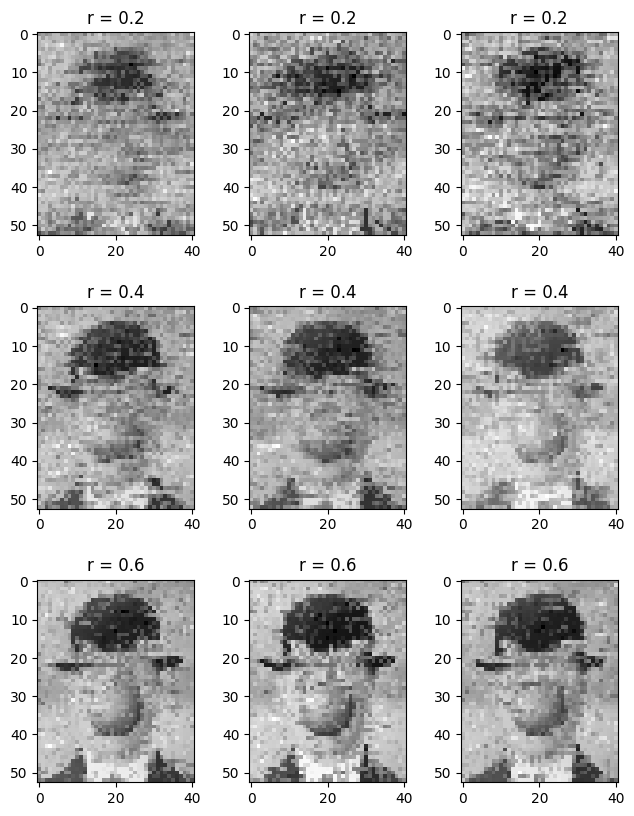

In [22]:
fig, ax = plt.subplots(3, 3, figsize=(30,15))
ax[0, 0].imshow(recovery_l1, cmap = 'gray')
ax[0, 0].set_title("r = 0.2")
ax[0, 1].imshow(recovery_l2, cmap = 'gray')
ax[0, 1].set_title("r = 0.2")
ax[0, 2].imshow(recovery_l3, cmap = 'gray')
ax[0, 2].set_title("r = 0.2")
ax[1, 0].imshow(recovery_l4, cmap = 'gray')
ax[1, 0].set_title("r = 0.4")
ax[1, 1].imshow(recovery_l5, cmap = 'gray')
ax[1, 1].set_title("r = 0.4")
ax[1, 2].imshow(recovery_l6, cmap = 'gray')
ax[1, 2].set_title("r = 0.4")
ax[2, 0].imshow(recovery_l7, cmap = 'gray')
ax[2, 0].set_title("r = 0.6")
ax[2, 1].imshow(recovery_l8, cmap = 'gray')
ax[2, 1].set_title("r = 0.6")
ax[2, 2].imshow(recovery_l9, cmap = 'gray')
ax[2, 2].set_title("r = 0.6")
plt.subplots_adjust(left=0.4,
                    bottom=0.1,
                    right=0.6,
                    top=0.6,
                    wspace=0.2,
                    hspace=0.35)
fig.savefig('Image_different_M.png')

In [23]:
path = 'UnknownImage.npz'
data = np.load(path)
B = data['B']
y = data['y']
DCT = construct_DCT_Mat(50, 50)
iDCT = construct_iDCT_Mat(50, 50)
A = np.dot(B, iDCT)
x = cvx.Variable(2500)
objective = cvx.Minimize(cvx.norm(x,1))
constraints = [A*x == y]
prob = cvx.Problem(objective, constraints)
prob.solve(solver = 'CVXOPT', verbose=True, max_iter= 1000, reltol=1e-2, featol = 1e-2)
recovery_unknown = np.matmul(iDCT, x.value)
recovery_unknown = recovery_unknown.reshape(50, 50)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Jul 28 09:53:59 PM: Your problem has 2500 variables, 2000 constraints, and 0 parameters.
(CVXPY) Jul 28 09:53:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 09:53:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 09:53:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 09:53:59 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:53:59 PM: Compiling problem (target solver=CVXOPT

/Users/sunhaolou/miniconda3/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 10 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Jul 28 09:54:00 PM: Applying reduction CVXOPT
(CVXPY) Jul 28 09:54:01 PM: Finished problem compilation (took 1.361e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 28 09:54:01 PM: Invoking solver CVXOPT  to obtain a solution.
     pcost       dcost       gap    pres   dres   k/t
 0: -1.1719e-14  1.0193e-15  3e+04  1e+03  9e-16  1e+00
 1:  2.9658e+01  3.0189e+01  1e+04  3e+02  3e-16  8e-01
 2:  7.2764e+01  7.2857e+01  1e+03  4e+01  4e-16  1e-01
 3:  2.0177e+02  2.0179e+02  3e+02  8e+00  1e-15  3e-02
 4:  2.8074e+02  2.8075e+02  1e+02  3e+00  2e-15  1e-02
 5:  3.0448e+02  3.0449e+02  4e+01  1e+00  2e-15  5e-03
 6:  3.1328e+02  3.1329e+02  2e+01  6e-01  2e-15  3e-03
 7:  3.1837e+02  3.1837e+02  8e+00  2e-01  3e-15  1e-03
 8:  3.2029e+02  3.2029e+02  3e+00  9e-02  3e-1

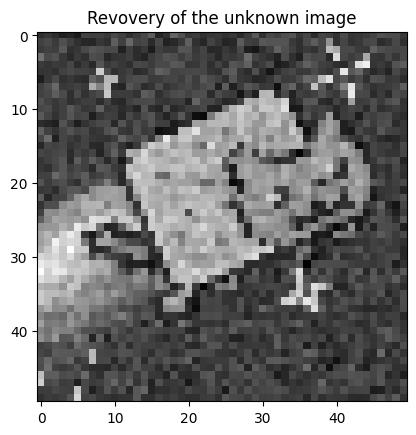

In [24]:
plt.imshow(recovery_unknown, cmap = 'gray')
plt.title('Revovery of the unknown image')
plt.savefig('recovery_unknown.png')